In [ ]:
#Brain tumor detection
#VGG16 model is used with ImageDataGenerator used in model fit

In [ ]:
import os
import numpy as np
import PIL
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import EarlyStopping
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt

In [ ]:
directory_yes = 'yes_crop_50_rgb/'
directory_no = 'no_crop_50_rgb/'

images_yes = []
images_no = []

shape = (224, 224)

for image in os.listdir(directory_yes):
    img = Image.open(directory_yes + image)
    img = img.resize(shape)
    img = np.array(img)
    images_yes.append(img)

for image in os.listdir(directory_no):
    img = Image.open(directory_no + image)
    img = img.resize(shape)
    img = np.array(img)
    images_no.append(img)

In [ ]:
images_yes = np.array(images_yes)
images_no = np.array(images_no)
print(images_yes.shape)
print(images_no.shape)
images = np.vstack((images_yes, images_no))
print(images.shape)

labels = [1]*images_yes.shape[0] + [0]*images_no.shape[0]
labels = list(map(float, labels))
labels = np.array(labels)
print(labels.shape)

(155, 224, 224, 3)
(98, 224, 224, 3)
(253, 224, 224, 3)
(253,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.33, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=12)  # 12, 36

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(169, 224, 224, 3)
(28, 224, 224, 3)
(56, 224, 224, 3)
(169,)
(28,)
(56,)


In [ ]:
train_datagen = ImageDataGenerator(rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True)

In [ ]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)
X_val = preprocess_input(X_val)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=X_train[0].shape)

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
model = tf.keras.models.Sequential([
  base_model,
  tf.keras.layers.Flatten(),
  #tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.layers[0].trainable = False

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['binary_accuracy'])

In [ ]:
batch_size = 32
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, seed=27, shuffle=True)

In [ ]:
early_stop = EarlyStopping(monitor='val_binary_accuracy',
                           patience=6,
                           mode='auto')

model_checkpoint =  ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_generator,
          epochs=50,
          steps_per_epoch=X_train.shape[0] // batch_size,
          validation_data=(X_val, y_val),
          callbacks=[early_stop, model_checkpoint])

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 6.0633 - binary_accuracy: 0.5255 
Epoch 1: val_loss improved from inf to 1.59368, saving model to best_model.h5
5/5 [==============================] - 105s 21s/step - loss: 6.0633 - binary_accuracy: 0.5255 - val_loss: 1.5937 - val_binary_accuracy: 0.7857
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 3.0279 - binary_accuracy: 0.7226 
Epoch 2: val_loss improved from 1.59368 to 0.89992, saving model to best_model.h5
5/5 [==============================] - 104s 21s/step - loss: 3.0279 - binary_accuracy: 0.7226 - val_loss: 0.8999 - val_binary_accuracy: 0.8393
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 2.7013 - binary_accuracy: 0.7518 
Epoch 3: val_loss improved from 0.89992 to 0.60557, saving model to best_model.h5
5/5 [==============================] - 103s 21s/step - loss: 2.7013 - binary_accuracy: 0.7518 - val_loss: 0.6056 - val_binary_accuracy: 0.9107
Epoch 4/50
5/5 [=============

In [ ]:
model.evaluate(X_test,  y_test)

1/1 [==============================] - 16s 16s/step - loss: 2.4504 - binary_accuracy: 0.8571


[2.4503695964813232, 0.8571428656578064]

In [ ]:
saved_model = load_model('best_model.h5')

In [ ]:
saved_model.evaluate(X_train, y_train)
saved_model.evaluate(X_val, y_val)
saved_model.evaluate(X_test, y_test)

1/1 [==============================] - 15s 15s/step - loss: 1.7425 - binary_accuracy: 0.8929


[1.7425038814544678, 0.8928571343421936]

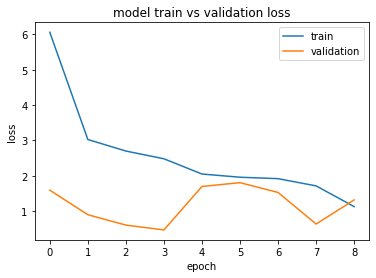

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')